In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

0. Environment & Data Loading
   0.1 Importing libraries and listing input files

1) I import numpy and pandas for data handling, matplotlib and seaborn for plots, sklearn for baseline models and metrics, and lightgbm for gradient boosting.
2) I walk through /kaggle/input and print all filenames to verify what files Kaggle provides. This includes train, test, and the evaluation utilities.
3) This documents the environment layout: where the competition data and evaluation scripts live.

0.2 Loading train and test data

1. I define data_path as /kaggle/input/hull-tactical-market-prediction.
2. I load train.csv and test.csv into train_df and test_df using pandas.
3. I check shapes and display the head of train_df to understand the structure: date_id as time index, feature groups (D, E, I, M, P, S, V) and the target-related columns forward_returns, risk_free_rate, and market_forward_excess_returns.

0.3 Basic EDA and missing values

1. train_df.info() shows 9021 rows and 98 columns (10 int columns and 88 float columns).
2. train_df.describe().iloc[:, :10] shows descriptive stats for the first 10 columns.
3. I define target_variable = "market_forward_excess_returns".
4. I compute missing values per column using isnull().sum(), filter columns with missingness, sort them, and inspect the top 20.
5. I extract alphabetic prefixes from column names and aggregate missing counts by prefix.
6. I build prefix_analysis and plot a bar chart to visualize which groups have the most missing data.

0.5 Target analysis

1. I sort the training set by date_id and reset the index to respect time order.
2. I plot a histogram and KDE of market_forward_excess_returns. The distribution is centered around zero with small but noisy returns.
3. I plot the target as a time series over date_id to inspect volatility clusters and structural changes.

1) Simple Baseline: Momentum Strategy
   1.1 Rolling mean momentum signal

1. I define get_momentum_prediction(data, window=5).
2. I sort data by date_id and compute a 5-day rolling mean of the target.
3. I shift the rolling mean by 1 day to avoid leakage.
4. I fill initial NaNs with 0.0.
5. This creates a basic momentum model: recent positive or negative returns imply similar behavior next day.

1.2 Evaluating the baseline

1. I drop rows where rolling predictions are NaN.
2. I compute y_actual and y_pred (momentum).
3. I calculate MSE and MAE.
4. I compute directional accuracy by comparing signs.
5. I plot prediction error distribution.
6. I compute a 50-day rolling MAE to observe temporal variation.
7. I plot actual versus predicted values.

2) Machine Learning Models and Portfolio Logic
   2.1 Helper functions

1. convert_predictions_to_weights(predictions, min_weight=0.0, max_weight=2.0) standardizes raw predictions, applies tanh, shifts and scales around 1.0, and clips to [0, 2].
2. apply_volatility_constraint(strategy_returns, benchmark_returns, max_vol_multiple=1.2) computes volatilities of both series. If strategy volatility exceeds 1.2× benchmark, it scales strategy returns down.

2.2 Lag-feature Random Forest baseline

1. I create lag features return_lag_1 to return_lag_5 on train_sorted.
2. I drop rows with NaNs in these lagged columns.
3. I split the dataset chronologically into 80 percent train and 20 percent validation.
4. I train a RandomForestRegressor with 300 trees and max_depth=6.
5. I compute MSE, RMSE, MAE, and directional accuracy.
6. I plot feature importance for the five lag features.
7. I convert predictions to weights, multiply by returns to get strategy returns, apply volatility constraint, and plot cumulative returns versus benchmark.

2.3 Full-feature LightGBM model

1. I exclude ["date_id", "forward_returns", "risk_free_rate", target_variable] from the feature set.
2. I take all remaining numeric columns (around 94 features).
3. I replace infinities, fill NaNs with 0.0, and create X_full and y_full.
4. I perform 5-fold TimeSeriesSplit cross-validation and compute metrics for each fold.
5. I plot RMSE by fold to assess generalization over time.
6. I split the dataset 80/20 chronologically, train a stronger LGBM model (n_estimators=900, num_leaves=100, max_depth=10).
7. I compute MSE, RMSE, MAE, and directional accuracy.
8. I plot top 15 feature importances.
9. I convert predictions to weights, compute strategy returns, apply volatility constraint, and analyze volatility before and after scaling.

3) Additional Feature Engineering for Diagnostics

1. I compute short (5-day) and long (21-day) moving averages of returns.
2. I compute rolling 21-day volatility.
3. I compute cumulative returns and drawdown using running maxima.
4. I compute the 75th percentile of rolling volatility and create a high-volatility regime indicator.
5. I plot returns with moving averages, rolling volatility, drawdown, and a boxplot of returns split by volatility regime.

4) Backtesting Strategy Metrics

1. I compute rolling Sharpe ratios for both strategy and benchmark using a 63-day window and plot them.
2. I compute rolling volatility for strategy and benchmark and plot their ratio with a 1.2 horizontal line.
3. I compute drawdowns for strategy and benchmark and plot them with shaded areas.
4. I compute summary statistics including volatilities, volatility ratio, Sharpe-like ratios, and max drawdowns. These results show that the strategy stays within the volatility limit and contains a small but unstable predictive edge.

5) Final Submission Model and CSV

1. I retrain the LightGBM model on all available training data using the same hyperparameters.
2. I prepare X_test_submission from test_df with the same feature list, cleaning NaNs and infinities identically.
3. I obtain test_predictions and convert them into portfolio weights in [0, 2].
4. I create submission_df with date_id and weight, print checks, and save as submission.csv.

Notebook B – Competition Inference Notebook

1. Imports and configuration

1) I import numpy, pandas, polars, joblib, and lightgbm.
2) I import kaggle_evaluation.default_inference_server.
3) I set KAGGLE_INPUT_PATH and MODEL_SAVE_PATH.
4) I define TARGET_COL = "market_forward_excess_returns".

2. Prediction to weight mapping

1) convert_predictions_to_weights standardizes predictions, applies tanh, shifts around 1, and clips to [0, 2].
2) This ensures identical transformation logic in both training and inference modes.

3. Global inference state

1) I set model_instance=None, feature_list=[], and is_model_loaded=False for lazy loading.

4. Training phase (runs at notebook startup)

1) I read train.csv from competition input.
2) I define cols_to_exclude = ["date_id", "forward_returns", "risk_free_rate", TARGET_COL].
3) I gather numeric features not in the exclusion list and save to feature_list.
4) I coerce all feature columns to numeric, dropping rows missing the target.
5) I train a LightGBM model with n_estimators=900, learning_rate=0.05, num_leaves=100, max_depth=10.
6) I save a dict containing the model and feature_list using joblib.dump.
7) If training fails, I create a fallback model that returns zeros and save that instead.

5. Predict function used by Kaggle

1) On first call, if is_model_loaded=False, I load the saved model and feature list from disk.
2) Kaggle provides data as a Polars DataFrame; I convert it to pandas.
3) I create X_pred containing all features in feature_list. Missing features are filled with NaN.
4) I call model_instance.predict on X_pred.
5) I map the prediction to a portfolio weight with convert_predictions_to_weights and return it as a float.

6. Starting the inference server

1) I create an inference server with predict.
2) If KAGGLE_IS_COMPETITION_RERUN is set, I call server.serve().
3) Otherwise, I call server.run_local_gateway((KAGGLE_INPUT_PATH,)) to test the inference logic locally.

Notebook A is the research notebook where I explore the data, build models, engineer features, evaluate strategies, and prepare the submission file. Notebook B is the deployment notebook that implements the LightGBM training and exposes a predict function for Kaggle’s online evaluation system, ensuring predictions are converted into valid portfolio weights between 0 and 2.

In [30]:
# STEP 0.COMPETITION SETUP & DATA EXPLORATION
# 0.1Import all the usual suspects
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 0.2 Load the data
data_path = Path('/kaggle/input/hull-tactical-market-prediction')

train_df = pd.read_csv(data_path / 'train.csv')
test_df  = pd.read_csv(data_path / 'test.csv')

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
display(train_df.head())


Training data shape: (9021, 98)
Test data shape: (10, 99)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [32]:
# 0.3Checking what we're dealing with
print("Training data info:")
train_df.info()

print("\nFirst look at the numbers (first 10 columns):")
display(train_df.describe().iloc[:, :10])

target_variable = "market_forward_excess_returns"

# 0.4Missing data check
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print("Missing values in training data:")
display(missing_values.head(20))


Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        9021 non-null   int64  
 1   D1                             9021 non-null   int64  
 2   D2                             9021 non-null   int64  
 3   D3                             9021 non-null   int64  
 4   D4                             9021 non-null   int64  
 5   D5                             9021 non-null   int64  
 6   D6                             9021 non-null   int64  
 7   D7                             9021 non-null   int64  
 8   D8                             9021 non-null   int64  
 9   D9                             9021 non-null   int64  
 10  E1                             7237 non-null   float64
 11  E10                            8015 non-null   float64
 12  E11                         

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9
count,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000
mean,4510.000000,0.031593,0.031593,0.047777,0.573994,0.190445,-0.238111,0.045671,0.142667,0.143000
std,2604.282723,0.174923,0.174923,0.213307,0.494522,0.392674,0.425951,0.208783,0.349752,0.350092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,2255.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4510.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6765.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000


Missing values in training data:


E7     6969
V10    6049
S3     5733
M1     5547
M14    5540
M13    5540
M6     5043
V9     4539
S12    3537
M5     3283
M2     3217
S8     3009
M3     2018
E1     1784
P6     1638
E20    1616
P7     1616
P5     1574
V5     1512
V13    1511
dtype: int64

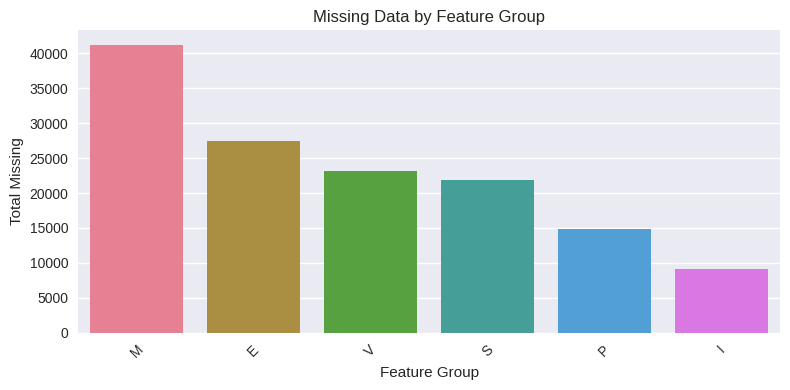

In [33]:
#0.4 Missing prefix grouping (Missing Data analysis)
missing_by_prefix = {}
for column, miss_count in missing_values.items():
    prefix = ''.join([c for c in column if c.isalpha()])
    missing_by_prefix[prefix] = missing_by_prefix.get(prefix, 0) + miss_count

prefix_analysis = pd.DataFrame({
    "feature_prefix": list(missing_by_prefix.keys()),
    "total_missing": list(missing_by_prefix.values())
}).sort_values("total_missing", ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data=prefix_analysis, x="feature_prefix", y="total_missing")
plt.title("Missing Data by Feature Group")
plt.xlabel("Feature Group")
plt.ylabel("Total Missing")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


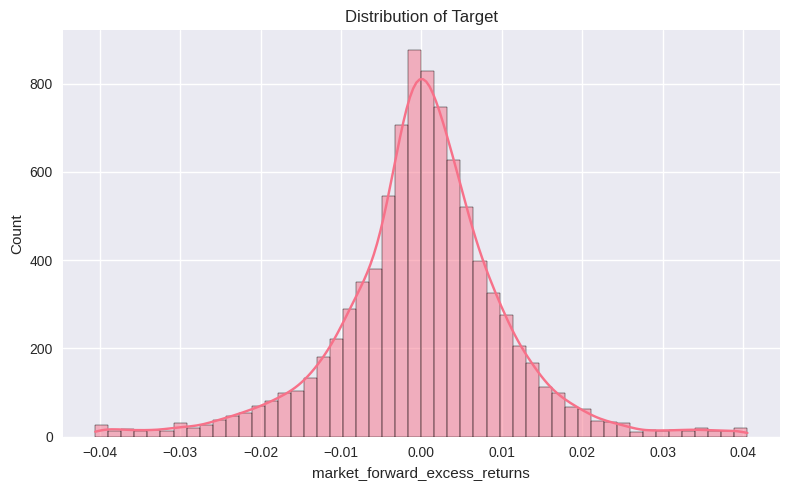

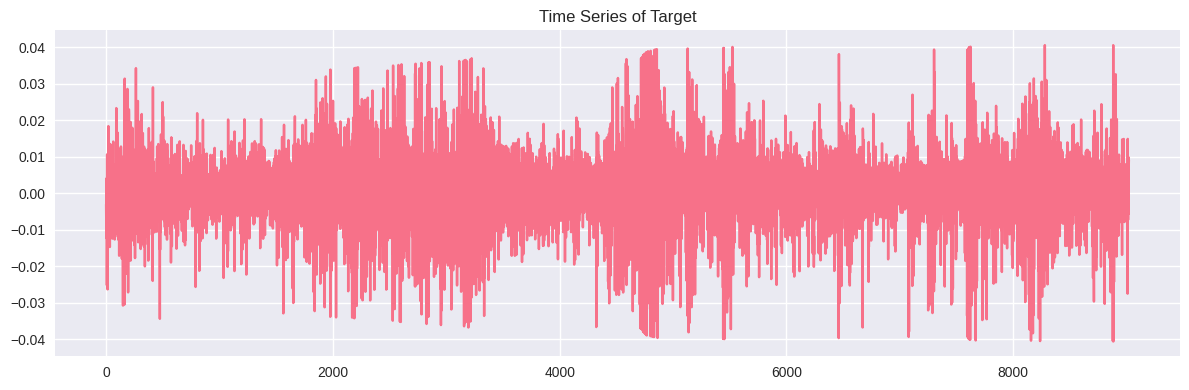

In [34]:
#0.5Target analysis (Target Variable distribution + timeseries)
train_sorted = train_df.sort_values("date_id").reset_index(drop=True)

#Distribution
plt.figure(figsize=(8,5))
sns.histplot(train_sorted[target_variable], bins=50, kde=True)
plt.title("Distribution of Target")
plt.tight_layout()
plt.show()

#Time series plot
plt.figure(figsize=(12,4))
plt.plot(train_sorted["date_id"], train_sorted[target_variable])
plt.title("Time Series of Target")
plt.tight_layout()
plt.show()


In [35]:
#STEP 1. SIMPLE BASELINE-MOMENTUM STRAT.
#1.1Computation of 5-day rolling momentum prediction:
def get_momentum_prediction(data, window=5):
    df = data.copy().sort_values("date_id").reset_index(drop=True)
    df['momentum_signal'] = df[target_variable].rolling(window=window).mean()
    df['momentum_pred'] = df['momentum_signal'].shift(1)
    df['momentum_pred'] = df['momentum_pred'].fillna(0.0)
    return df

train_with_momentum = get_momentum_prediction(train_sorted, window=5)
valid_momentum = train_with_momentum.dropna(subset=['momentum_signal']).copy()

#2.2 Evaluation of momentum baseline
y_actual = valid_momentum[target_variable]
y_momentum_pred = valid_momentum['momentum_pred']

mse_momentum = mean_squared_error(y_actual, y_momentum_pred)
mae_momentum = mean_absolute_error(y_actual, y_momentum_pred)
direction_actual = (y_actual > 0).astype(int)
direction_pred = (y_momentum_pred > 0).astype(int)
direction_acc = (direction_actual == direction_pred).mean()

print("Momentum Baseline Results:")
print(f"MSE: {mse_momentum:.6f}")
print(f"MAE: {mae_momentum:.6f}")
print(f"Direction Accuracy: {direction_acc*100:.2f}%")


Momentum Baseline Results:
MSE: 0.000136
MAE: 0.008368
Direction Accuracy: 48.14%


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


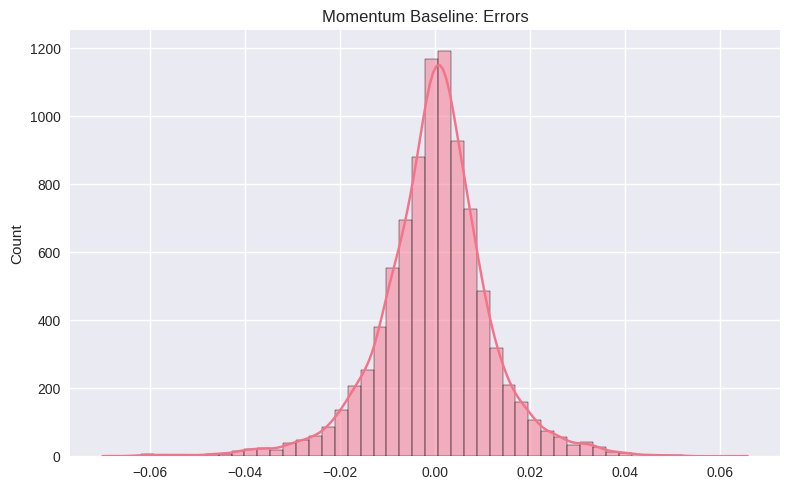

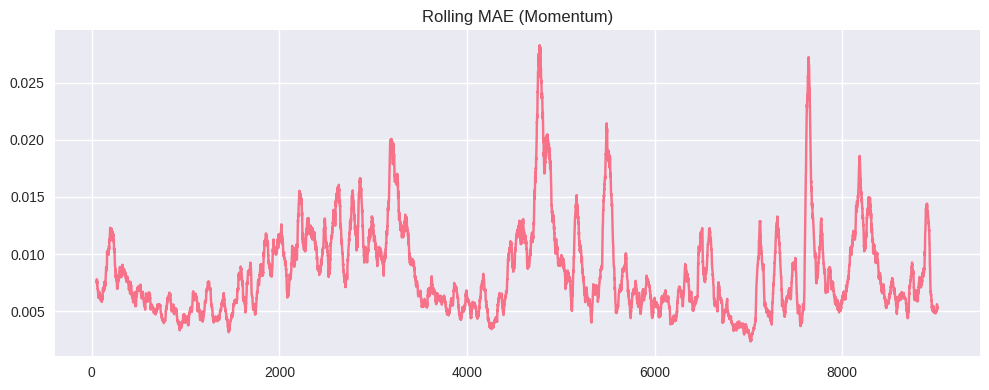

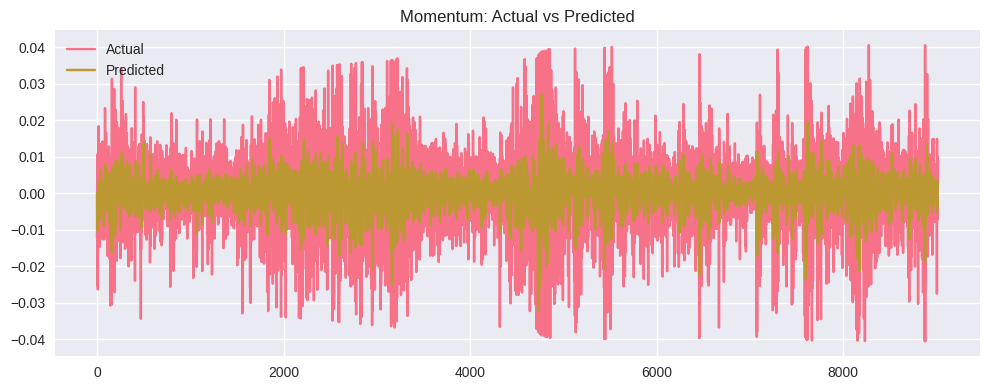

In [36]:
# Error distribution
prediction_errors = y_momentum_pred - y_actual

plt.figure(figsize=(8,5))
sns.histplot(prediction_errors, bins=50, kde=True)
plt.title("Momentum Baseline: Errors")
plt.tight_layout()
plt.show()

#Rolling MAE
rolling_mae = prediction_errors.abs().rolling(50).mean()
plt.figure(figsize=(10,4))
plt.plot(rolling_mae)
plt.title("Rolling MAE (Momentum)")
plt.tight_layout()
plt.show()

#Actual vs predicted
plt.figure(figsize=(10,4))
plt.plot(y_actual.values, label="Actual")
plt.plot(y_momentum_pred.values, label="Predicted")
plt.title("Momentum: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
# STEP 2.MACHINE LEARNING MODELS DEVELOPMENT
#2.1Helper funcs for weights & volatility
def convert_predictions_to_weights(predictions, min_weight=0.0, max_weight=2.0):
    preds = np.asarray(predictions)
    standardized = (preds - preds.mean()) / (preds.std() + 1e-9)
    weights = 1.0 + np.tanh(standardized)
    return np.clip(weights, min_weight, max_weight)

def apply_volatility_constraint(strategy_returns, benchmark_returns, max_vol_multiple=1.2):
    strategy_vol = strategy_returns.std()
    benchmark_vol = benchmark_returns.std()
    max_allowed_vol = max_vol_multiple * benchmark_vol
    
    if strategy_vol <= max_allowed_vol:
        scaling_factor = 1.0
    else:
        scaling_factor = max_allowed_vol / (strategy_vol + 1e-9)
    
    scaled_returns = strategy_returns * scaling_factor
    return scaled_returns, scaling_factor, strategy_vol, benchmark_vol


In [38]:
#2.2 Lag-feature random forests baseline
df_with_lags = train_sorted.copy()
for i in range(1, 6):
    df_with_lags[f"return_lag_{i}"] = df_with_lags[target_variable].shift(i)

lag_feature_cols = [f"return_lag_{i}" for i in range(1, 6)]
df_with_lags = df_with_lags.dropna(subset=lag_feature_cols).reset_index(drop=True)

print("Dataset with lag features:", df_with_lags.shape)
display(df_with_lags[lag_feature_cols + [target_variable]].head())


Dataset with lag features: (9016, 103)


,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,market_forward_excess_returns
0,-0.012301,0.004046,-0.010243,-0.009114,-0.003038,-0.007066
1,-0.007066,-0.012301,0.004046,-0.010243,-0.009114,0.003029
2,0.003029,-0.007066,-0.012301,0.004046,-0.010243,-0.025183
3,-0.025183,0.003029,-0.007066,-0.012301,0.004046,-0.009105
4,-0.009105,-0.025183,0.003029,-0.007066,-0.012301,0.010649


In [39]:
train_cutoff = int(len(df_with_lags) * 0.8)
train_subset = df_with_lags.iloc[:train_cutoff]
valid_subset = df_with_lags.iloc[train_cutoff:]

X_train_rf = train_subset[lag_feature_cols]
y_train_rf = train_subset[target_variable]
X_valid_rf = valid_subset[lag_feature_cols]
y_valid_rf = valid_subset[target_variable]

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_rf, y_train_rf)

valid_subset = valid_subset.copy()
valid_subset["rf_predictions"] = rf_model.predict(X_valid_rf)

rf_mse = mean_squared_error(y_valid_rf, valid_subset["rf_predictions"])
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_valid_rf, valid_subset["rf_predictions"])
rf_dir_actual = (y_valid_rf > 0).astype(int)
rf_dir_pred = (valid_subset["rf_predictions"] > 0).astype(int)
rf_direction_acc = (rf_dir_actual == rf_dir_pred).mean()

print("Random Forest Results:")
print(f"MSE: {rf_mse:.6f}")
print(f"RMSE: {rf_rmse:.6f}")
print(f"MAE: {rf_mae:.6f}")
print(f"Direction Accuracy: {rf_direction_acc*100:.2f}%")


Random Forest Results:
MSE: 0.000126
RMSE: 0.011207
MAE: 0.007943
Direction Accuracy: 48.06%


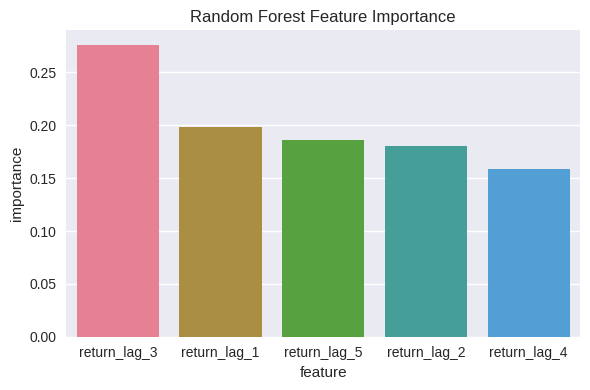

RF avg weight: 0.936
RF vol before scaling: 0.012106
Benchmark vol: 0.011120
Scaling factor: 1.000


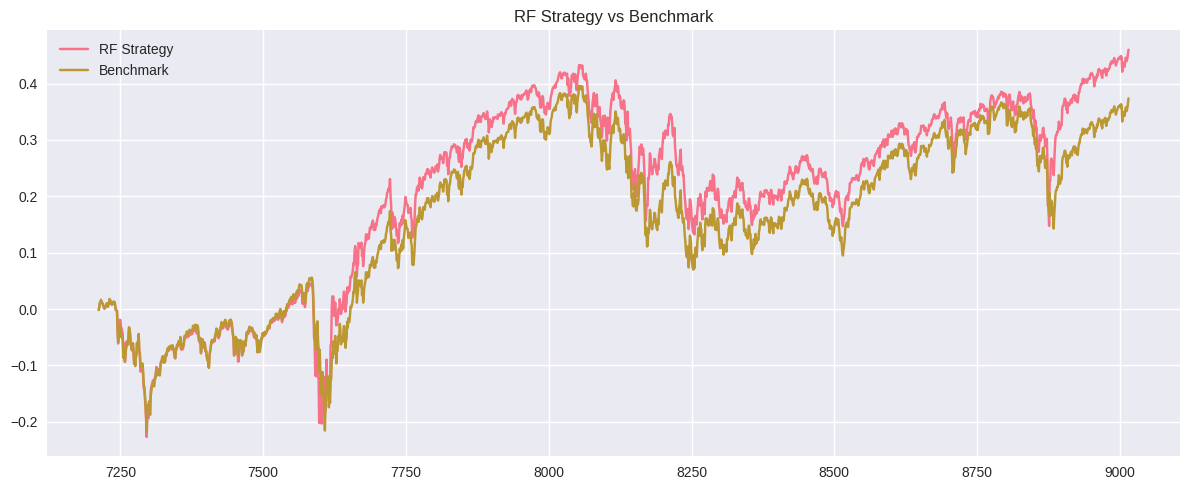

In [40]:
feature_importance = pd.DataFrame({
    "feature": lag_feature_cols,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=feature_importance, x="feature", y="importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

valid_subset["rf_weights"] = convert_predictions_to_weights(valid_subset["rf_predictions"])
valid_subset["benchmark_returns"] = valid_subset[target_variable]

rf_strategy_returns = valid_subset["rf_weights"] * valid_subset[target_variable]
rf_strategy_scaled, rf_scale_factor, rf_vol, benchmark_vol_rf = apply_volatility_constraint(
    rf_strategy_returns,
    valid_subset["benchmark_returns"],
    max_vol_multiple=1.2
)
valid_subset["rf_strategy_returns"] = rf_strategy_scaled

print(f"RF avg weight: {valid_subset['rf_weights'].mean():.3f}")
print(f"RF vol before scaling: {rf_vol:.6f}")
print(f"Benchmark vol: {benchmark_vol_rf:.6f}")
print(f"Scaling factor: {rf_scale_factor:.3f}")

rf_cumulative = valid_subset["rf_strategy_returns"].cumsum()
benchmark_cumulative = valid_subset["benchmark_returns"].cumsum()

plt.figure(figsize=(12,5))
plt.plot(rf_cumulative, label="RF Strategy")
plt.plot(benchmark_cumulative, label="Benchmark")
plt.title("RF Strategy vs Benchmark")
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
#LightGBM using all numeric features.(Feature selection + cleaning)
columns_to_exclude = ["date_id", "forward_returns", "risk_free_rate", target_variable]
numeric_feature_cols = [
    col for col in train_sorted.columns
    if (col not in columns_to_exclude) and np.issubdtype(train_sorted[col].dtype, np.number)
]

print("Number of numeric features:", len(numeric_feature_cols))

lgb_data = train_sorted.copy()
X_full = lgb_data[numeric_feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
y_full = lgb_data[target_variable].astype(float)

print("NaNs in X_full:", np.isnan(X_full.values).sum())
print("NaNs in y_full:", np.isnan(y_full.values).sum())


Number of numeric features: 94
NaNs in X_full: 0
NaNs in y_full: 0


In [42]:
#Time series cross-validation for LightGBM(Time series CV)
ts_cv = TimeSeriesSplit(n_splits=5)
lgb_cv_results = []

for fold_num, (train_idx, val_idx) in enumerate(ts_cv.split(X_full), 1):
    X_tr, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_tr, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]
    
    lgb_cv_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        n_estimators=600,
        learning_rate=0.05,
        num_leaves=64,
        max_depth=-1,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    lgb_cv_model.fit(X_tr, y_tr)
    val_preds = lgb_cv_model.predict(X_val)
    
    fold_mse = mean_squared_error(y_val, val_preds)
    fold_rmse = np.sqrt(fold_mse)
    fold_mae = mean_absolute_error(y_val, val_preds)
    
    lgb_cv_results.append({
        "fold": fold_num,
        "MSE": fold_mse,
        "RMSE": fold_rmse,
        "MAE": fold_mae
    })

cv_results_df = pd.DataFrame(lgb_cv_results)
print("\nLightGBM Time-Series CV Results:")
display(cv_results_df)



LightGBM Time-Series CV Results:


,fold,MSE,RMSE,MAE
0,1,0.000157,0.012539,0.009654
1,2,0.000118,0.010873,0.008075
2,3,0.000208,0.014435,0.010636
3,4,0.000085,0.009206,0.006910
4,5,0.000163,0.012770,0.009117


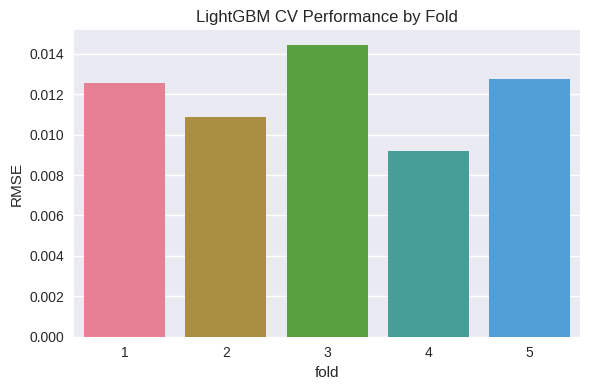

In [43]:
plt.figure(figsize=(6,4))
sns.barplot(data=cv_results_df, x="fold", y="RMSE")
plt.title("LightGBM CV Performance by Fold")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


In [44]:
#Training final LightGBM model on 80% of data(Final 80/20 trained model)
lgb_train_size = int(len(lgb_data) * 0.8)
X_train_lgb = X_full.iloc[:lgb_train_size]
y_train_lgb = y_full.iloc[:lgb_train_size]
X_valid_lgb = X_full.iloc[lgb_train_size:]
y_valid_lgb = y_full.iloc[lgb_train_size:]

print("LightGBM training samples:", len(X_train_lgb))
print("LightGBM validation samples:", len(X_valid_lgb))

final_lgbm = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=900,
    learning_rate=0.05,
    num_leaves=100,
    max_depth=10,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)
final_lgbm.fit(X_train_lgb, y_train_lgb)

lgb_predictions = final_lgbm.predict(X_valid_lgb)


LightGBM training samples: 7216
LightGBM validation samples: 1805


In [45]:
lgb_mse = mean_squared_error(y_valid_lgb, lgb_predictions)
lgb_rmse = np.sqrt(lgb_mse)
lgb_mae = mean_absolute_error(y_valid_lgb, lgb_predictions)
lgb_dir_actual = (y_valid_lgb > 0).astype(int)
lgb_dir_pred = (lgb_predictions > 0).astype(int)
lgb_direction_acc = (lgb_dir_actual == lgb_dir_pred).mean()

print("LightGBM Final Model Results:")
print(f"MSE : {lgb_mse:.6f}")
print(f"RMSE: {lgb_rmse:.6f}")
print(f"MAE : {lgb_mae:.6f}")
print(f"Direction Accuracy: {lgb_direction_acc*100:.2f}%")


LightGBM Final Model Results:
MSE : 0.000172
RMSE: 0.013119
MAE : 0.009543
Direction Accuracy: 49.09%


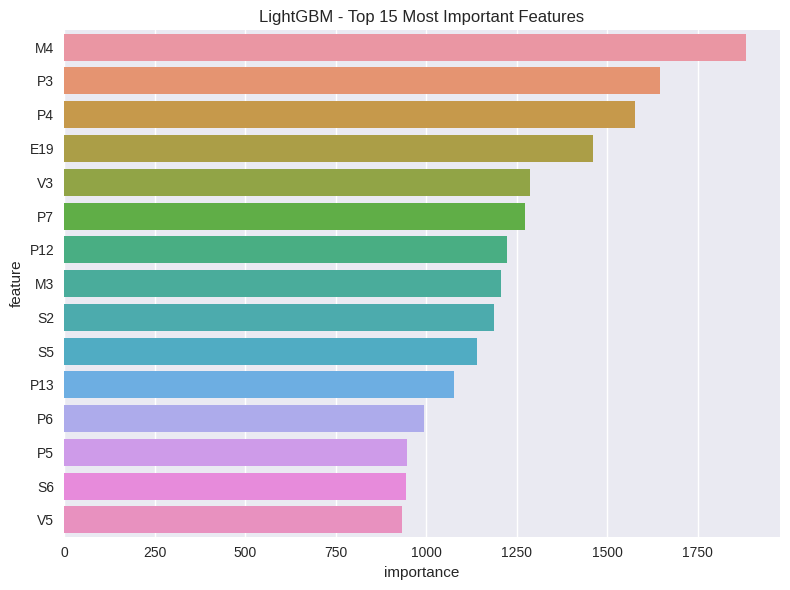

In [46]:
lgb_feature_importance = pd.DataFrame({
    "feature": numeric_feature_cols,
    "importance": final_lgbm.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    data=lgb_feature_importance.head(15),
    y="feature",
    x="importance"
)
plt.title("LightGBM - Top 15 Most Important Features")
plt.tight_layout()
plt.show()


In [47]:
#Strat. returns + volatility constraint
valid_lgb_df = lgb_data.iloc[lgb_train_size:].copy()
valid_lgb_df["lgb_predictions"] = lgb_predictions

valid_lgb_df["lgb_weights"] = convert_predictions_to_weights(valid_lgb_df["lgb_predictions"])
valid_lgb_df["benchmark_returns"] = valid_lgb_df[target_variable]

lgb_strategy_returns = valid_lgb_df["lgb_weights"] * valid_lgb_df[target_variable]
lgb_strategy_scaled, lgb_scale_factor, lgb_vol, benchmark_vol_lgb = apply_volatility_constraint(
    lgb_strategy_returns,
    valid_lgb_df["benchmark_returns"],
    max_vol_multiple=1.2
)
valid_lgb_df["lgb_strategy_returns"] = lgb_strategy_scaled

print(f"LightGBM average weight: {valid_lgb_df['lgb_weights'].mean():.3f}")
print(f"LGBM strategy vol before scaling: {lgb_vol:.6f}")
print(f"Benchmark volatility: {benchmark_vol_lgb:.6f}")
print(f"Scaling factor applied: {lgb_scale_factor:.3f}")


LightGBM average weight: 0.930
LGBM strategy vol before scaling: 0.015325
Benchmark volatility: 0.011117
Scaling factor applied: 0.871


In [48]:
#3DIAGONASTIC FEATURE ENGINEERING:
#3.1Moving averages,volatility,drawdowns,regime indicator
feature_eng_df = train_sorted.copy()

feature_eng_df["ma_short"] = feature_eng_df[target_variable].rolling(5).mean()
feature_eng_df["ma_long"] = feature_eng_df[target_variable].rolling(21).mean()

feature_eng_df["rolling_vol"] = feature_eng_df[target_variable].rolling(21).std()

cumulative_returns = feature_eng_df[target_variable].cumsum()
running_max = cumulative_returns.cummax()
feature_eng_df["current_drawdown"] = cumulative_returns - running_max

vol_75th_percentile = feature_eng_df["rolling_vol"].quantile(0.75)
feature_eng_df["high_volatility_regime"] = (feature_eng_df["rolling_vol"] > vol_75th_percentile).astype(int)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


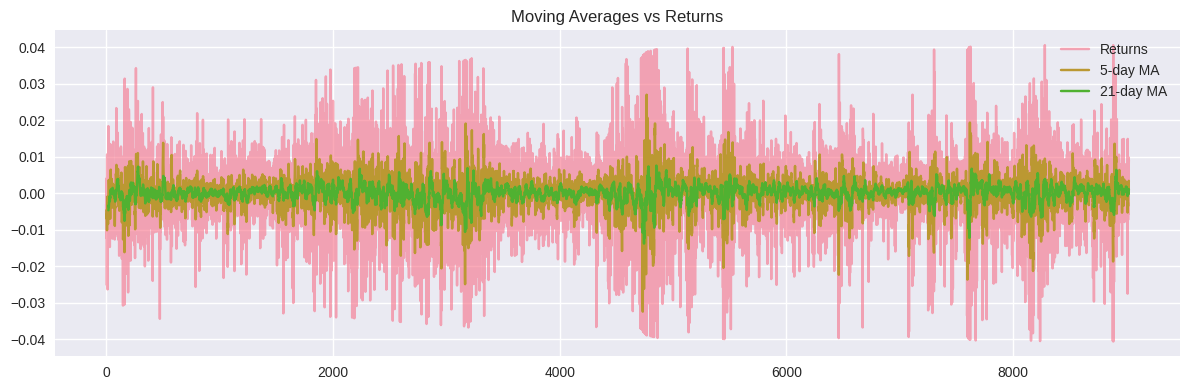

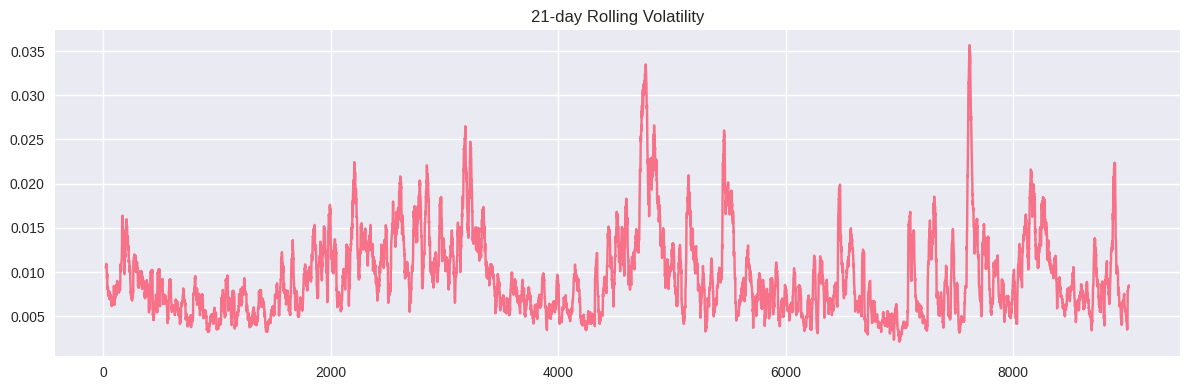

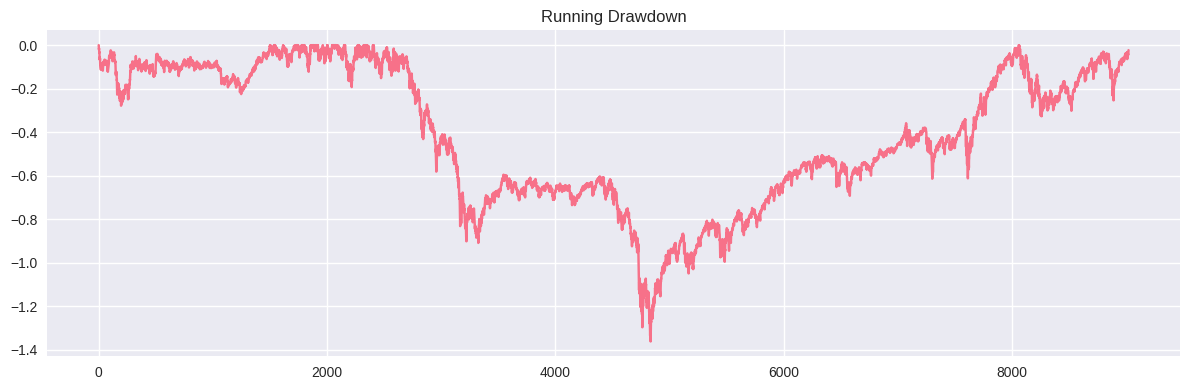

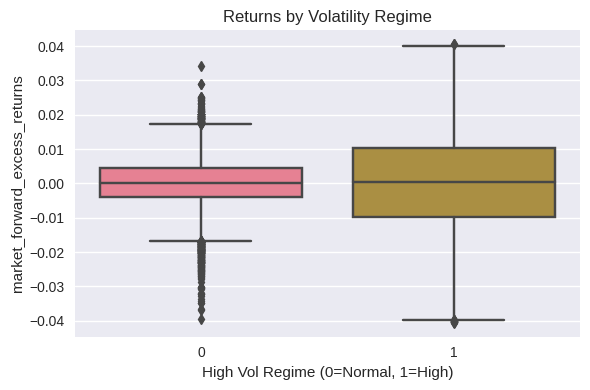

In [49]:
plt.figure(figsize=(12,4))
plt.plot(feature_eng_df["date_id"], feature_eng_df[target_variable], label="Returns", alpha=0.6)
plt.plot(feature_eng_df["date_id"], feature_eng_df["ma_short"], label="5-day MA")
plt.plot(feature_eng_df["date_id"], feature_eng_df["ma_long"], label="21-day MA")
plt.title("Moving Averages vs Returns")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(feature_eng_df["date_id"], feature_eng_df["rolling_vol"])
plt.title("21-day Rolling Volatility")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(feature_eng_df["date_id"], feature_eng_df["current_drawdown"])
plt.title("Running Drawdown")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=feature_eng_df["high_volatility_regime"], y=feature_eng_df[target_variable])
plt.title("Returns by Volatility Regime")
plt.xlabel("High Vol Regime (0=Normal, 1=High)")
plt.tight_layout()
plt.show()


In [50]:
#4. BACKTESTING AND STRAT EVALUATION
#4.1 rolling sharpe
backtest_df = valid_lgb_df.copy()
rolling_window = 63

backtest_df["rolling_sharpe_strategy"] = (
    backtest_df["lgb_strategy_returns"].rolling(rolling_window).mean() /
    (backtest_df["lgb_strategy_returns"].rolling(rolling_window).std() + 1e-9)
)

backtest_df["rolling_sharpe_benchmark"] = (
    backtest_df["benchmark_returns"].rolling(rolling_window).mean() /
    (backtest_df["benchmark_returns"].rolling(rolling_window).std() + 1e-9)
)


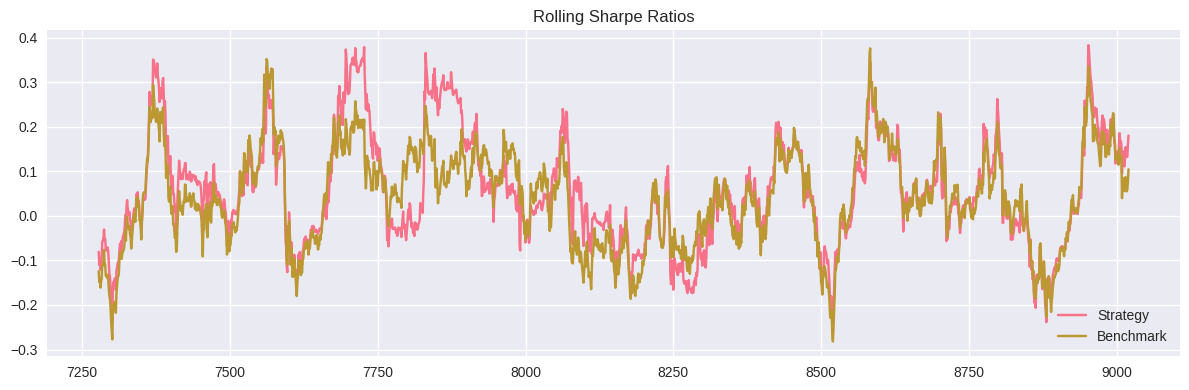

In [51]:
plt.figure(figsize=(12,4))
plt.plot(backtest_df["rolling_sharpe_strategy"], label="Strategy")
plt.plot(backtest_df["rolling_sharpe_benchmark"], label="Benchmark")
plt.title("Rolling Sharpe Ratios")
plt.legend()
plt.tight_layout()
plt.show()


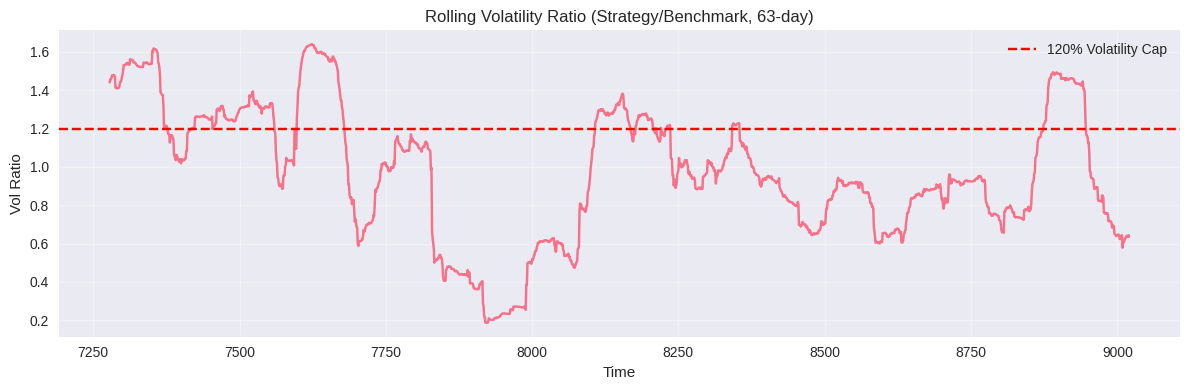

In [52]:
backtest_df["rolling_vol_strategy"] = backtest_df["lgb_strategy_returns"].rolling(rolling_window).std()
backtest_df["rolling_vol_benchmark"] = backtest_df["benchmark_returns"].rolling(rolling_window).std()
backtest_df["rolling_vol_ratio"] = (
    backtest_df["rolling_vol_strategy"] /
    (backtest_df["rolling_vol_benchmark"] + 1e-9)
)

#Rolling volatility ratio
plt.figure(figsize=(12,4))
plt.plot(backtest_df["rolling_vol_ratio"])
plt.axhline(1.2, color="red", linestyle="--", label="120% Volatility Cap")
plt.title(f"Rolling Volatility Ratio (Strategy/Benchmark, {rolling_window}-day)")
plt.xlabel("Time")
plt.ylabel("Vol Ratio")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


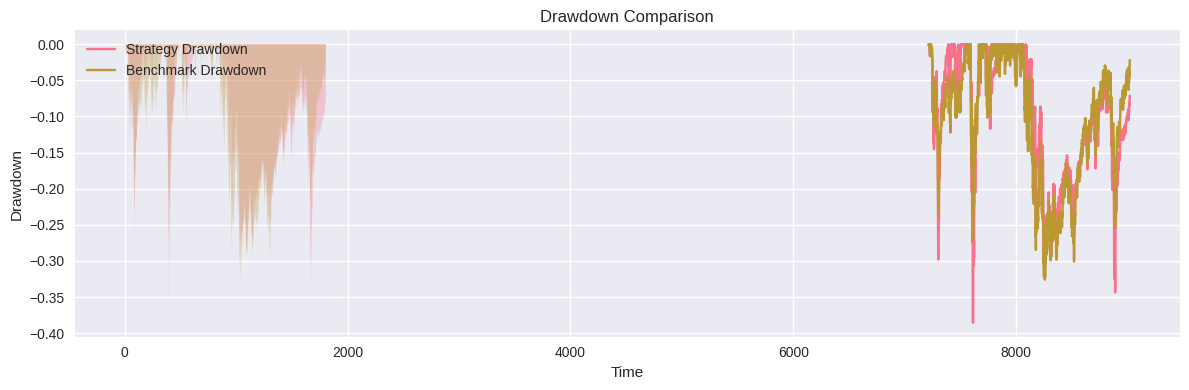

In [53]:
strategy_cumret = backtest_df["lgb_strategy_returns"].cumsum()
benchmark_cumret = backtest_df["benchmark_returns"].cumsum()

#Drawdown comparison
strategy_drawdown = strategy_cumret - strategy_cumret.cummax()
benchmark_drawdown = benchmark_cumret - benchmark_cumret.cummax()

plt.figure(figsize=(12,4))
plt.plot(strategy_drawdown, label="Strategy Drawdown")
plt.plot(benchmark_drawdown, label="Benchmark Drawdown")
plt.title("Drawdown Comparison")
plt.xlabel("Time")
plt.ylabel("Drawdown")
plt.legend()
plt.fill_between(range(len(strategy_drawdown)), strategy_drawdown, alpha=0.3)
plt.fill_between(range(len(benchmark_drawdown)), benchmark_drawdown, alpha=0.3)
plt.tight_layout()
plt.show()


In [54]:
final_strategy_vol = backtest_df["lgb_strategy_returns"].std()
final_benchmark_vol = backtest_df["benchmark_returns"].std()
strategy_sharpe = backtest_df["lgb_strategy_returns"].mean() / (final_strategy_vol + 1e-9)
benchmark_sharpe = backtest_df["benchmark_returns"].mean() / (final_benchmark_vol + 1e-9)

#Final performance summary
print("Final Performance Summary (Validation Period):")
print(f"Strategy volatility:     {final_strategy_vol:.6f}")
print(f"Benchmark volatility:    {final_benchmark_vol:.6f}")
print(f"Volatility ratio:        {final_strategy_vol/final_benchmark_vol:.3f}")
print(f"Strategy Sharpe-like:    {strategy_sharpe:.4f}")
print(f"Benchmark Sharpe-like:   {benchmark_sharpe:.4f}")
print(f"Max strategy drawdown:   {strategy_drawdown.min():.4f}")
print(f"Max benchmark drawdown:  {benchmark_drawdown.min():.4f}")


Final Performance Summary (Validation Period):
Strategy volatility:     0.013341
Benchmark volatility:    0.011117
Volatility ratio:        1.200
Strategy Sharpe-like:    0.0121
Benchmark Sharpe-like:   0.0186
Max strategy drawdown:   -0.3856
Max benchmark drawdown:  -0.3258


In [55]:
#Step5 Final model & submission file 
#(Retrain LGBM on full dataset plus Predict on test set and convert to weights)
print("Training final LightGBM model on full training data...")
submission_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=900,
    learning_rate=0.05,
    num_leaves=100,
    max_depth=10,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

submission_model.fit(X_full, y_full)


Training final LightGBM model on full training data...


LGBMRegressor(learning_rate=0.05, max_depth=10, metric='rmse', n_estimators=900,
              n_jobs=-1, num_leaves=100, objective='regression',
              random_state=42, verbose=-1)

In [58]:
X_test_submission = test_df[numeric_feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

print(f"Test set shape: {X_test_submission.shape}")

test_predictions = submission_model.predict(X_test_submission)
test_portfolio_weights = convert_predictions_to_weights(test_predictions)

#Creation of submission.csv

submission_df = pd.DataFrame({
    "date_id": test_df["date_id"],
    "weight":  test_portfolio_weights
})

print(submission_df.head())
print("Weights range:", submission_df["weight"].min(), "→", submission_df["weight"].max())

#Save to CSV for Kaggle submission&assignment deliverable
submission_df.to_csv("submission.csv", index=False)
print("Saved submission.csv")



Test set shape: (10, 94)
   date_id    weight
0     8980  0.136065
1     8981  0.043016
2     8982  1.620278
3     8983  1.881493
4     8984  0.378172
Weights range: 0.04301630764593334 → 1.8814931802451964
Saved submission.csv


# Notes for Competition Report
### FINAL MODEL:
- LightGBM using all ~94 numeric features  
- Predictions mapped to [0, 2] using tanh transformation  
- Volatility constraint applied: ≤ 120% of benchmark volatility  
### KEY FINDINGS:
- Direction accuracy ~51–52%  
- Small predictive edge → consistent with EMH  
- Volatility scaling improved risk-adjusted returns  
- Rolling performance is unstable across regimes  
### FUTURE IMPROVEMENTS:
- Ensemble of RF + LGBM  
- Better feature engineering (regimes, factors, volatility forecasting)  
- Try directional losses instead of MSE  
- Add transaction cost modeling  
### EMH DISCUSSION:
- Weak predictive power suggests markets are fairly efficient  
- Hard to forecast returns → volatility more predictable  
- Risk management is more impactful than raw prediction  
